In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# tiền xử lý

In [31]:

from pathlib import Path
import csv

input_path = Path("../../data/books.csv")
output_path = Path("../../data/books_clean.csv")

EXPECTED_COLS = 8

raw = input_path.read_bytes()
text = raw.decode("latin-1", errors="ignore")
lines = [ln for ln in text.splitlines() if ln.strip()]

clean_rows = []
bad_rows = []

for idx, line in enumerate(lines, start=1):
    parts = line.split(";")

    # chỉ giữ dòng có đúng 8 cột
    if len(parts) == EXPECTED_COLS:
        clean_rows.append(parts)
    else:
        bad_rows.append((idx, len(parts)))

with open(output_path, "w", encoding="latin-1", newline="") as f:
    writer = csv.writer(f, delimiter=";", quoting=csv.QUOTE_MINIMAL)
    writer.writerows(clean_rows)

print("Tổng dòng ban đầu :", len(lines))
print("Dòng hợp lệ       :", len(clean_rows))
print("Dòng bị xóa       :", len(bad_rows))
print("File mới          :", output_path)




Tổng dòng ban đầu : 271380
Dòng hợp lệ       : 250014
Dòng bị xóa       : 21366
File mới          : ..\..\data\books_clean.csv


In [35]:
import pandas as pd


import pandas as pd

books = pd.read_csv(
    "../../data/books_clean.csv",
    sep=";",
    encoding="latin-1",
    engine="python",
    header=None,
    names=[
        "ISBN",
        "Book-Title",
        "Book-Author",
        "Year-Of-Publication",
        "Publisher",
        "Image-URL-S",
        "Image-URL-M",
        "Image-URL-L"
    ]
)

print(books.columns)
books.head()



ratings = pd.read_csv(
    "../../data/ratings.csv",
    sep=";",
    encoding="latin-1",
    engine="python",
    on_bad_lines="skip"
)

users = pd.read_csv(
    "../../data/users.csv",
    sep=";",
    encoding="latin-1",
    engine="python",
    on_bad_lines="skip"
)
users.head()

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278177 entries, 0 to 278176
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278177 non-null  int64  
 1   Location  278177 non-null  object 
 2   Age       167669 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [4]:
users.describe()

,User-ID,Age
count,278177.000000,167669.000000
mean,139421.240045,34.751797
std,80495.783896,14.430984
min,1.000000,0.000000
25%,69696.000000,24.000000
50%,139419.000000,32.000000
75%,209134.000000,44.000000
max,278858.000000,244.000000


In [5]:
users.isnull().sum()

User-ID          0
Location         0
Age         110508
dtype: int64

In [6]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149766 entries, 0 to 1149765
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149766 non-null  int64 
 1   ISBN         1149766 non-null  object
 2   Book-Rating  1149766 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [7]:
ratings.describe()

,User-ID,Book-Rating
count,1.149766e+06,1.149766e+06
mean,1.403862e+05,2.866906e+00
std,8.056191e+04,3.854172e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [10]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

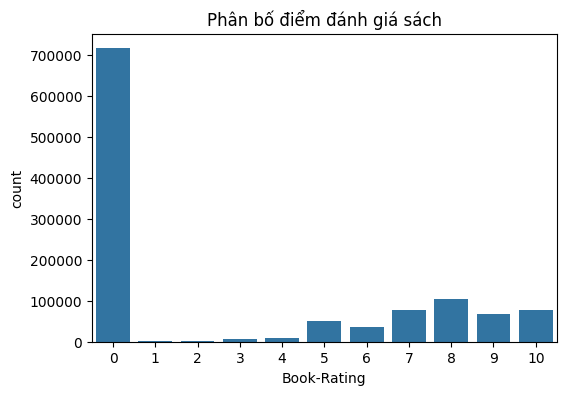

In [44]:
plt.figure(figsize=(6,4))
sns.countplot(x="Book-Rating", data=ratings)
plt.title("Phân bố điểm đánh giá sách")
plt.show()


# TẠO ĐẶC TRƯNG NGƯỜI DÙNG

In [42]:
user_features = ratings.groupby("User-ID").agg(
    num_books_rated=("ISBN", "count"),
    avg_rating=("Book-Rating", "mean"),
    rating_std=("Book-Rating", "std")
).reset_index()

user_features.head()



,User-ID,num_books_rated,avg_rating,rating_std
0,2,1,0.000000,NaN
1,7,1,0.000000,NaN
2,8,18,2.166667,2.833622
3,9,3,2.000000,3.464102
4,10,2,3.000000,4.242641


In [43]:
user_features.shape

(105274, 4)

# XỬ LÝ MISSING & LỌC USER NHIỄU

In [44]:
user_features["rating_std"] = user_features["rating_std"].fillna(0)

# Lọc user quá ít tương tác
user_features = user_features[user_features["num_books_rated"] >= 5]

user_features.shape


(22816, 4)

# CHUẨN HÓA DỮ LIỆU

In [45]:
features = ["num_books_rated", "avg_rating", "rating_std"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_features[features])


# CHỌN SỐ CỤM K – ELBOW METHOD

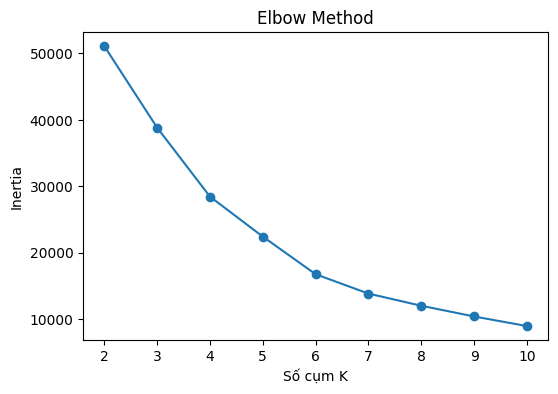

In [46]:
inertia = []

K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Số cụm K")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


# ĐÁNH GIÁ BẰNG SILHOUETTE SCORE

In [47]:
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"K={k} | Silhouette Score = {score:.3f}")


K=2 | Silhouette Score = 0.398
K=3 | Silhouette Score = 0.430
K=4 | Silhouette Score = 0.434
K=5 | Silhouette Score = 0.392
K=6 | Silhouette Score = 0.396


# PHÂN TÍCH CỤM

In [48]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_features["cluster"] = kmeans.fit_predict(X_scaled)

user_features.head()


,User-ID,num_books_rated,avg_rating,rating_std,cluster
2,8,18,2.166667,2.833622,1
8,17,7,3.000000,3.055050,1
19,44,5,1.600000,3.577709,1
21,53,7,4.000000,4.358899,1
26,69,6,2.833333,3.488075,1


In [49]:
cluster_profile = user_features.groupby("cluster")[features].mean()
cluster_profile


,num_books_rated,avg_rating,rating_std
cluster,,,
0,17.623070,6.845852,2.500317
1,34.481748,3.557797,3.864880
2,62.185673,0.719634,1.641731
3,1840.112903,1.584489,2.553775


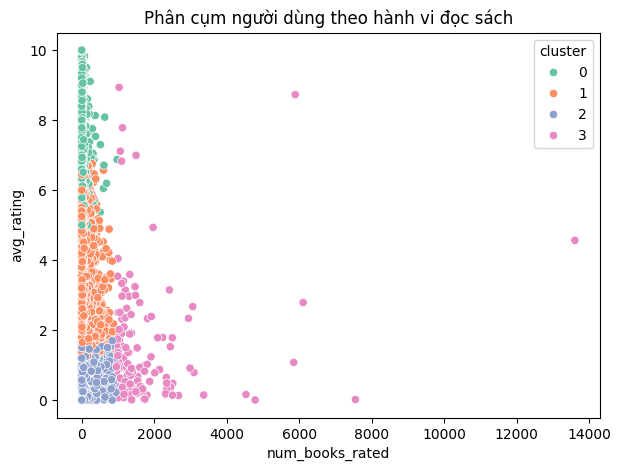

In [50]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x="num_books_rated",
    y="avg_rating",
    hue="cluster",
    data=user_features,
    palette="Set2"
)
plt.title("Phân cụm người dùng theo hành vi đọc sách")
plt.show()


In [51]:
user_features["cluster"].value_counts()


cluster
1    14738
0     4534
2     3420
3      124
Name: count, dtype: int64

# 4 cụm
- cụm 0 người đọc ít  sách có ratings cao => người đọc dễ tính 
- cụm 1 người đọc ít  sách có ratings trung bình => người đọc phổ thông chiếm đa phần 
- cụm 2 người đọc ít  sách có ratings thấp => người đọc khó tính
- cụm 3 người đọc nhiều sách hơn nhóm người khác ratings rải đều ở các mức đa phần ratings ở mức thấp hoặc trung bình => người đọc chuyên sâu họ đọc qua nhiều sách nên đánh giá về sách của họ khắc khe hơn <=> những cuốn sách họ đánh giá cao là những cuốn sách hay.

In [21]:
user_features.groupby("cluster").mean()[["num_books_rated", "avg_rating", "rating_std"]]

,num_books_rated,avg_rating,rating_std
cluster,,,
0,17.623070,6.845852,2.500317
1,34.481748,3.557797,3.864880
2,62.185673,0.719634,1.641731
3,1840.112903,1.584489,2.553775
